<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset el libro de la republica de platon

In [9]:

with open('./dataset/the_republic.txt') as f:
    content = f.readlines()

content = [x.strip() for x in content] 
df = pd.DataFrame(content)
df.head()

,0
0,ï»¿The Project Gutenberg EBook of The Republic...
1,
2,This eBook is for the use of anyone anywhere i...
3,other parts of the world at no cost and with a...
4,"whatsoever. You may copy it, give it away or ..."


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 29809


### 1 - Preprocesamiento

In [4]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [20]:
import numpy as np

In [25]:
stack = np.hstack(sentence_tokens)

In [31]:
stack.shape[0]

258534

In [37]:
vector_size = int(np.ceil(np.power(stack.shape[0],1/4)))
vector_size

23

In [5]:
# Demos un vistazo
sentence_tokens[:2]

[['ï»¿the',
  'project',
  'gutenberg',
  'ebook',
  'of',
  'the',
  'republic',
  'of',
  'plato',
  'by',
  'plato'],
 []]

### 2 - Crear los vectores (word2vec)

In [38]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [39]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=vector_size,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=3,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [40]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [41]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 29809


In [43]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4010


### 3 - Entrenar el modelo generador

In [44]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 630487.9375
Loss after epoch 1: 519304.9375
Loss after epoch 2: 467257.125
Loss after epoch 3: 461609.375
Loss after epoch 4: 413810.625
Loss after epoch 5: 414142.25
Loss after epoch 6: 413305.25
Loss after epoch 7: 407560.25
Loss after epoch 8: 411015.5
Loss after epoch 9: 383091.25
Loss after epoch 10: 378321.0
Loss after epoch 11: 375245.0
Loss after epoch 12: 374793.0
Loss after epoch 13: 373159.5
Loss after epoch 14: 375390.5
Loss after epoch 15: 374026.5
Loss after epoch 16: 370656.5
Loss after epoch 17: 372069.0
Loss after epoch 18: 374258.5
Loss after epoch 19: 374856.5


(3329820, 5170680)

### 4 - Ensayar

In [45]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["republic"], topn=10)

[('analysis', 0.8943947553634644),
 ('books', 0.8700664043426514),
 ('recapitulation', 0.8519642353057861),
 ('illustrations', 0.8395475149154663),
 ('fifth', 0.8312342762947083),
 ('book', 0.8252779841423035),
 ('introduction', 0.813823938369751),
 ('sixth', 0.8078795075416565),
 ('philebus', 0.7945286631584167),
 ('illustration', 0.7799142003059387)]

In [47]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('step', -0.06567389518022537),
 ('an', -0.1022576242685318),
 ('long', -0.10838895291090012),
 ('next', -0.11208948493003845),
 ('question', -0.12896351516246796),
 ('further', -0.14914344251155853),
 ('proceed', -0.15357527136802673),
 ('might', -0.153673455119133),
 ('point', -0.15982511639595032),
 ('shall', -0.16030746698379517)]

In [48]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["achilles"], topn=10)

[('apollo', 0.8838510513305664),
 ('herã¨', 0.864963173866272),
 ('phoenix', 0.8625845313072205),
 ('391', 0.8592227697372437),
 ('388', 0.8527556657791138),
 ('392', 0.8486714959144592),
 ('wounded', 0.844336748123169),
 ('chryses', 0.8439027070999146),
 ('orpheus', 0.8419549465179443),
 ('ares', 0.8405547738075256)]

In [49]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["socrates"], topn=5)

[('thrasymachus', 0.9268650412559509),
 ('adeimantus', 0.9110367894172668),
 ('polemarchus', 0.9009115099906921),
 ('cephalus', 0.8904650211334229),
 ('cleitophon', 0.8832603693008423)]

In [50]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["cicero"], topn=5)

[('translated', 0.8817545771598816),
 ('opening', 0.8783665299415588),
 ('characterized', 0.872977077960968),
 ('philebus', 0.8719514012336731),
 ('comic', 0.8713939785957336)]

In [51]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["diedaa"])

KeyError: "Key 'diedaa' not present in vocabulary"

### 5 - Visualizar agrupación de vectores

In [52]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key )  

    tsne = TSNE(n_components=num_dimensions, random_state=0, n_jobs= -1)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [97]:
# Graficar los embedddings en 2D
# import plotly.graph_objects as go
# import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
# fig = plt.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
# fig.show() # esto para plotly en colab

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

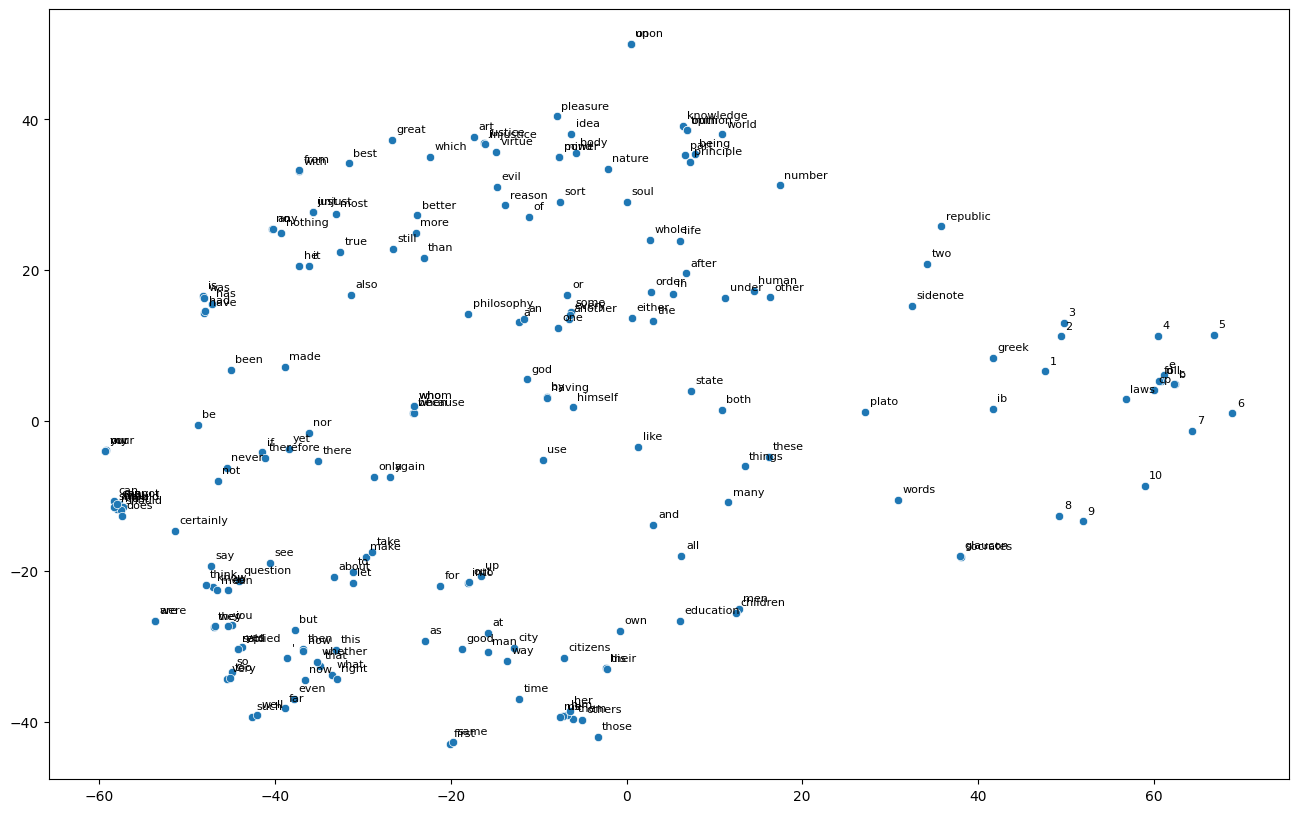

In [99]:
MAX_WORDS=200
plt.figure(figsize=(16,10))
fig = sns.scatterplot(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS])
for i, language in enumerate (labels[:MAX_WORDS]):

    plt.text(x_vals[i]+0.5,y_vals[i]+1,language, fontsize=8)



### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

# Cambios realizados

- Se utilizo el libro de la republica de platon como dataset, extraido de gutenberg project.
- Se ajusto el numero de embeddings mediante el metodo empirico de la raiz cuarta. 
- Se probaron terminos de interes como, republic, achilles, etc, y se encontraron las palabras con mayor similitud.

# Conclusiones

- La dimension de los embeddings, cambian considerablemente el loss de entrenamiento.
- Al buscar las palabras similares a "achilles" se encontro que los embeddings mapearon a otros personajes de la historia.
